In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

import numpy as np
import pandas as pd
import tdt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from hc_extension import *

In [2]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac_csvs"
brain_region = '#15616F'

# NAc: #15616F
# mPFC: #FFAF00

In [3]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac/nn4-250121-084228/Notes.txt
read from t=0s to t=1861.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac/nn7-250121-094048/Notes.txt
read from t=0s to t=1839.16s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac/nn8-250121-101912/Notes.txt
read from t=0s to t=1836.57s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac/nn6-250120-085156/Notes.txt
read from t=0s to t=1779.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac/nn5-250120-081227/Notes.txt
read from t=0s to t=1772.86s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-3/C3_Home_Cage/nac/nn1-250120-063024/Notes.txt
read from t=0s to t=1833.87s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohor

In [4]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions)

Processing behaviors for nn4-250121-084228...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for nn6-250120-085156...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn1-250120-063024...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn2-250120-072910...


## Total Investigation Time & Average Bout Duration

In [5]:
def get_trial_dataframes(experiment):
    """
    Given an Experiment object, return a list of DataFrames,
    where each DataFrame corresponds to the .behaviors of each trial.
    """
    # Extract all trial IDs from the experiment
    trial_ids = list(experiment.trials.keys())

    # Retrieve a DataFrame of behaviors for each trial
    trial_dataframes = [experiment.trials[tid].behaviors for tid in trial_ids]

    return trial_dataframes


def process_investigation_data(df, 
                               behavior_name='Investigation', 
                               gap_threshold=1.0, 
                               min_duration=0.5,
                               desired_bouts=None,
                               agg_func='sum'):
    """
    Merge consecutive Investigation events within 'gap_threshold' seconds,
    remove events shorter than 'min_duration', then group/pivot by Subject & Bout.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: [Subject, Behavior, Bout, Event_Start, Event_End, Duration (s)]
    behavior_name : str
        Which behavior to combine/filter (default 'Investigation').
    gap_threshold : float
        Max gap (in seconds) to consider consecutive events mergeable.
    min_duration : float
        Minimum duration below which events are removed.
    desired_bouts : list or None
        Which bouts to keep (if None, keep all).
    agg_func : {'sum', 'mean'}
        How to combine the durations in the final group step.
        
    Returns
    -------
    pivot_df : pd.DataFrame
        Pivoted DataFrame of aggregated durations by Subject × Bout.
    """
    
    #--- 1) Keep only rows matching the specified behavior ---
    df = df[df["Behavior"] == behavior_name].copy()
    
    #--- 2) Sort so consecutive events are truly consecutive by subject & start time ---
    df.sort_values(["Subject", "Event_Start"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    #--- 3) Identify which rows should *not* merge with their predecessor ---
    df["new_block"] = (
        (df["Subject"] != df["Subject"].shift(1)) |
        (df["Event_Start"] - df["Event_End"].shift(1) > gap_threshold)
    )
    df["group_id"] = df["new_block"].cumsum()
    
    #--- 4) Merge consecutive events in each group_id ---
    merged = (
        df.groupby("group_id", as_index=False)
          .agg({
              "Subject":      "first",
              "Behavior":     "first",
              "Bout":         "first",  # Uses the first bout label in the block
              "Event_Start":  "min",
              "Event_End":    "max",
              "Duration (s)": "sum"
          })
    )
    
    #--- 5) Remove events shorter than min_duration ---
    merged = merged[merged["Duration (s)"] >= min_duration].copy()
    
    #--- 6) Filter by desired bouts (if provided) ---
    if desired_bouts is not None:
        merged = merged[merged["Bout"].isin(desired_bouts)]
    
    #--- 7) Group by Subject & Bout with either sum or mean, then pivot ---
    if agg_func == 'sum':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
    elif agg_func == 'mean':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
    else:
        raise ValueError("agg_func must be either 'sum' or 'mean'")
    
    pivot_df = (
        grouped_df
        .pivot(index="Subject", columns="Bout", values="Duration (s)")
        .fillna(0)
    )
    
    return pivot_df

def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.
    
    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        
        # Assign this entire CSV to one Subject
        temp_df["Subject"] = subject_id
        
        # Calculate sums and average for this subject
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()  # how many unique bouts in this CSV
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        # Attach these values to every row
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1  # next CSV -> next Subject
    
    # Concatenate all into a single DataFrame
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df


In [6]:
get_trial_dataframes(experiment)

[            Bout       Behavior  Event_Start  Event_End  Duration (s)
 0    Long_Term-1       Approach       1189.8   1190.799         0.999
 1    Long_Term-1       Approach       1200.0   1202.199         2.199
 2    Long_Term-1  Investigation       1190.8   1193.100         2.300
 3    Long_Term-1  Investigation       1202.2   1203.500         1.300
 4    Long_Term-1  Investigation       1209.0   1209.400         0.400
 5    Long_Term-1  Investigation       1247.6   1250.400         2.800
 6    Long_Term-1  Investigation       1264.7   1265.100         0.400
 7    Long_Term-1  Investigation       1308.0   1308.300         0.300
 8    Long_Term-1  Investigation       1384.8   1385.600         0.800
 9    Long_Term-1  Investigation       1398.9   1401.100         2.200
 10   Long_Term-1  Investigation       1407.7   1410.800         3.100
 11   Long_Term-1  Investigation       1428.9   1429.200         0.300
 12   Long_Term-1  Investigation       1448.9   1460.300        11.400
 13   

In [7]:
desired_bouts = ["Short_Term-1", "Short_Term-2", "Long_Term-1", "Novel-1"]

dfs = get_trial_dataframes(experiment)
ready_df = create_subject_summary_df(dfs)

pivot = process_investigation_data(
    ready_df,
    behavior_name="Investigation",   # or "Approach" if you prefer
    gap_threshold=0.3,
    min_duration=.00000000000000001,
    desired_bouts=desired_bouts,
    agg_func='sum'
)

In [8]:
# Define the desired order of the bars
desired_order = ["Acq-ST", "Short Term", "Long Term", "Novel"]

# Map original bout names to new labels
bout_rename_mapping = {
    "Short_Term-1": "Acq-ST",
    "Short_Term-2": "Short Term",
    "Long_Term-1": "Long Term",
    "Novel-1": "Novel"
}

# Rename columns in pivot_df
pivot_df = pivot.rename(columns=bout_rename_mapping)

# Reorder columns based on desired order
pivot_df = pivot_df[desired_order]

In [9]:
def plot_y_across_bouts_gray(df,  
                             title='Mean Across Bouts', 
                             ylabel='Mean Value', 
                             custom_xtick_labels=None, 
                             custom_xtick_colors=None, 
                             ylim=None, 
                             bar_color='#00B7D7',
                             yticks_increment=None, 
                             xlabel='Agent',
                             figsize=(12,7), 
                             pad_inches=0.1):
    """
    Plots the mean values (with SEM) across bouts with individual-subject lines.
    Also performs a paired t-test comparing the average of s1-1 & s1-2 vs. the
    average of s1-5 & s2-2, drawing a significance line if p < 0.05.

    Parameters:
        - df (DataFrame): A DataFrame where rows are subjects, and bouts are columns.
                          Values are the mean values (e.g., mean DA, investigation times)
                          for each subject and bout.
        - title (str): The title for the plot.
        - ylabel (str): The label for the y-axis.
        - custom_xtick_labels (list): Custom x-tick labels. If not provided,
                                      defaults to df column names.
        - custom_xtick_colors (list): A list of colors for the x-tick labels.
        - ylim (tuple): (min, max) for y-axis. If None, automatically set.
        - bar_color (str): The color for the bars.
        - yticks_increment (float): Increment for y-axis ticks.
        - xlabel (str): The label for the x-axis.
        - figsize (tuple): The figure size.
        - pad_inches (float): Figure padding when saving.
    """
    """
    Plots the mean values during investigations or other events across bouts with error bars for SEM,
    and individual subject lines connecting the bouts. All subjects are plotted in gray.

    Performs t-tests and plots significance markers above bars.
    """

    def perform_t_tests(df):
        """Performs paired t-tests comparing Acq-ST with Short Term, Long Term, and Novel using pivot_df."""
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }

        results = {}

        for key, (bout1, bout2) in comparisons.items():
            if bout1 in df.columns and bout2 in df.columns:
                # Drop NaN values and ensure equal-length pairs
                paired_df = df[[bout1, bout2]].dropna()
                
                if len(paired_df) > 1:  # Ensure enough data points for paired t-test
                    t_stat, p_value = ttest_rel(paired_df[bout1], paired_df[bout2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        
        return results

    # Compute t-test results using the nested function
    t_test_results = perform_t_tests(df)

    # Calculate mean and SEM
    mean_values = df.mean()
    sem_values = df.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # Bar plot with error bars
    bars = ax.bar(
        df.columns, 
        mean_values, 
        yerr=sem_values, 
        capsize=6,
        color=bar_color,
        edgecolor='black', 
        linewidth=5,
        width=0.6,
        error_kw=dict(elinewidth=3, capthick=3, zorder=5)
    )

    # Plot all subject lines in gray
    for subject in df.index:
        ax.plot(df.columns, df.loc[subject],
                linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

    # Plot unfilled circle markers (larger size) in gray
    for subject in df.index:
        ax.scatter(df.columns, df.loc[subject], 
                   facecolors='none', edgecolors='gray',
                   s=120, alpha=0.6, linewidth=4, zorder=2)

    # Labels & Title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # Set x-ticks
    ax.set_xticks(np.arange(len(df.columns)))
    if custom_xtick_labels is not None:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors is not None:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(df.columns, fontsize=26)

    # Increase tick label size
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # Handle y-limits
    if ylim is None:
        # Automatically set based on data range
        all_values = np.concatenate([df.values.flatten(), mean_values.values.flatten()])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # Set y-ticks if increment is provided
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min),
                            np.ceil(y_max) + yticks_increment,
                            yticks_increment)
        ax.set_yticks(y_ticks)

    # Remove right & top spines, thicken left & bottom
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # ---- Plot significance markers ---- #
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05  # Offset above bars

        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }

        line_spacing = sig_y_offset * 2.5  # Adjust to separate significance lines
        current_y = mean_values.max() + sig_y_offset  # Initial line position

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*" 

                    # Draw horizontal line
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)

                    # Add asterisks centered above the line
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance, 
                            fontsize=40, ha='center', color='black')

                    # Move the next line slightly higher to avoid overlap
                    current_y += line_spacing

    #plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout()
    plt.show()
    

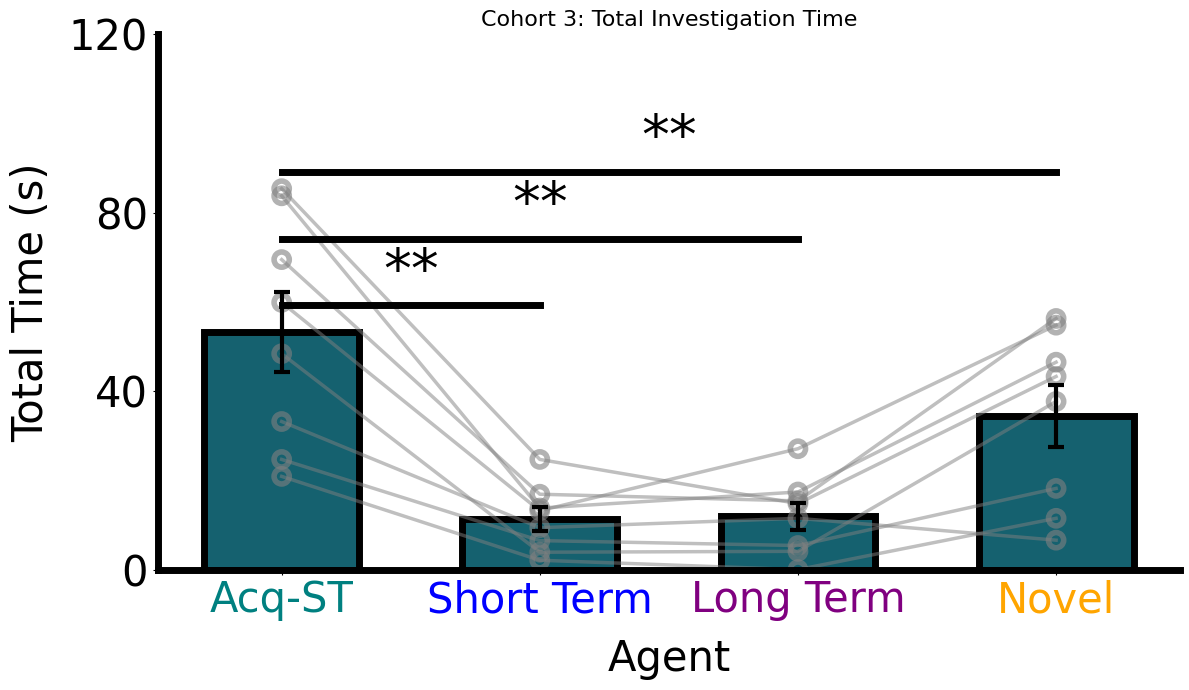

In [10]:
plot_y_across_bouts_gray(
    df=pivot_df,
    title="Cohort 3: Total Investigation Time",
    ylabel="Total Time (s)",
    custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(0,120),
    yticks_increment=40,
    bar_color=brain_region,
    xlabel="Agent",
    figsize=(12,7),
    pad_inches=0.1
)

## Global DA

In [11]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first = True)

# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(
    use_fractional=True,       # Enable fractional analysis (limits window to max_bout_duration)
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    peak_fall_fraction=0.6,    # Set the fall threshold to 60% of the peak
    allow_bout_extension=True, # Allow extending the bout window if needed
    first=True                 # Consider only the first investigation event per bout
)

Processing behaviors for nn4-250121-084228...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for nn6-250120-085156...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn1-250120-063024...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn2-250120-072910...
Computing DA metrics for nn4-250121-084228 ...
Computing DA metrics for nn7-250121-094048 ...
Computing DA metrics for nn8-250121-101912 ...
Computing DA metrics for nn6-250120-085156 ...
Computing DA metrics for nn5-250120-081227 ...
Computing DA metrics for nn1-250120-063024 ...
Computing DA metrics for nn3-250121-074834 ...
Computing DA metrics for nn2-250120-072910 ...


In [12]:
def plot_da_metrics_combined_oneplot_integrated(experiment, 
                                                metric_name="Mean Z-score", 
                                                title="Combined DA Metrics", 
                                                ylabel="DA Metric", 
                                                xlabel="Bout", 
                                                custom_xtick_labels=None, 
                                                custom_xtick_colors=None, 
                                                ylim=None, 
                                                bar_color="#00B7D7", 
                                                yticks_increment=None, 
                                                figsize=(14,8), 
                                                pad_inches=0.1):
    """
    Plots DA metrics across specific bouts for all trials in the experiment.
    If p-value < 0.05, it adds a horizontal significance line + asterisk above bars.

    Updates:
    - Unfilled circle markers for individual trials
    - Thick grey outlines for visibility
    """

    def perform_t_tests(pivot_df):
        """Performs paired t-tests comparing Acq-ST with Short Term, Long Term, and Novel."""
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }

        results = {}

        for key, (bout1, bout2) in comparisons.items():
            if bout1 in pivot_df.columns and bout2 in pivot_df.columns:
                paired_df = pivot_df[[bout1, bout2]].dropna()
                
                if len(paired_df) > 1:
                    t_stat, p_value = ttest_rel(paired_df[bout1], paired_df[bout2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        
        return results

    # Collect per-trial data for the chosen metric
    trial_data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and not trial.behaviors.empty:
            trial_df = trial.behaviors.copy()
            if metric_name not in trial_df.columns:
                print(f"Warning: Trial '{trial_name}' does not contain metric '{metric_name}'. Skipping.")
                continue
            df_grouped = trial_df.groupby("Bout", as_index=False)[metric_name].mean()
            df_grouped["Trial"] = trial_name
            trial_data.append(df_grouped)
        else:
            print(f"Warning: Trial '{trial_name}' has no behavior data.")

    if not trial_data:
        print("No data available to plot.")
        return

    # Combine all trial data into a single DataFrame.
    combined_df = pd.concat(trial_data, ignore_index=True)

    # Select only 6 bouts
    selected_bouts = combined_df["Bout"].unique()[:6]
    combined_df = combined_df[combined_df["Bout"].isin(selected_bouts)]

    # Pivot the data for line plots: rows=Trial, columns=Bout, values=metric_name
    try:
        pivot_df = combined_df.pivot(index="Trial", columns="Bout", values=metric_name).fillna(0)
    except Exception as e:
        print("Error pivoting data for line plots:", e)
        return

    # Compute overall average and SEM for each Bout
    overall_stats = combined_df.groupby("Bout")[metric_name].agg(['mean', 'sem']).reset_index()

    # Now that pivot_df is created, perform t-tests
    t_test_results = perform_t_tests(pivot_df)

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the overall average as a bar chart with error bars
    ax.bar(overall_stats["Bout"], overall_stats["mean"], yerr=overall_stats["sem"],
           capsize=6, color=bar_color, edgecolor='black', linewidth=5, width=0.6,
           error_kw=dict(elinewidth=3, capthick=3, zorder=5))
    
    # Overlay individual trial lines (all in gray)
    for trial in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[trial], linestyle='-', color='gray', 
                alpha=0.5, linewidth=3, marker='o', markerfacecolor='none', 
                markeredgecolor='gray', markeredgewidth=2, markersize=10)

    # Set labels and title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=28)

    # Set exactly 6 x-tick labels
    xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"]
    xtick_colors=["teal", "blue", "purple", "orange"]

    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(xtick_labels, fontsize=28)

    # Apply custom colors
    for tick, color in zip(ax.get_xticklabels(), xtick_colors):
        tick.set_color(color)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)
    
    # Set y-limits
    if ylim is None:
        all_values = np.concatenate([pivot_df.values.flatten(), overall_stats["mean"].values])
        ax.set_ylim(0, np.nanmax(all_values) * 1.2)
    else:
        ax.set_ylim(ylim)

    ax.axhline(y=0, color='black', linestyle='--', linewidth=2)

    # Set y-ticks increment
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        ax.set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment))

    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # ---- Plot significance markers ---- #
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05  # Offset above bars

        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }

        line_spacing = sig_y_offset * 2.5  # Adjust spacing between lines
        current_y = np.nanmax(overall_stats["mean"]) + sig_y_offset  # Initial line position

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*" 

                    # Draw horizontal line
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)

                    # Add asterisks centered above the line
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance, 
                            fontsize=40, ha='center', color='black')

                    # Move the next line slightly higher to avoid overlap
                    current_y += line_spacing

    #plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout(pad=pad_inches)
    plt.show()


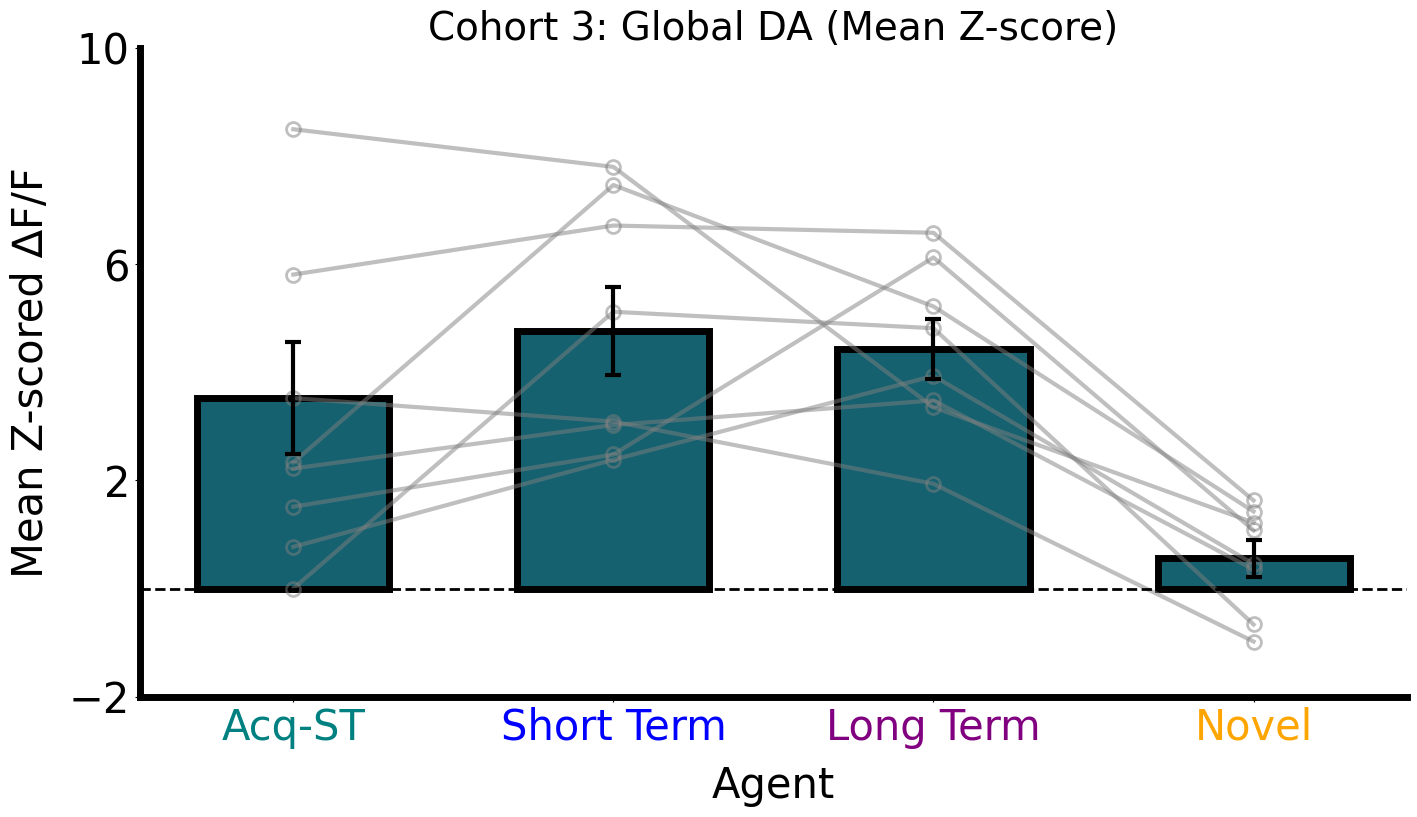

In [ ]:
from scipy.stats import ttest_rel

plot_da_metrics_combined_oneplot_integrated(experiment,
                                                metric_name="Mean Z-score", 
                                                title="Cohort 3: Global DA (Mean Z-score)", 
                                                ylabel="Mean Z-scored ∆F/F", 
                                                xlabel="Agent", 
                                                custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
                                                custom_xtick_colors=["teal", "blue", "purple", "orange"], 
                                                ylim=(-2, 10), 
                                                bar_color=brain_region, 
                                                yticks_increment=4, 
                                                figsize=(14,8), 
                                                pad_inches=0.1)

# Mean Z-scored ∆F/F

## Ranks Stuff

In [14]:
import pandas as pd

def assign_subject_ranks_to_experiment(experiment, rank_csv_path):
    """
    Loads subject ranks from CSV and assigns each trial’s .behaviors DataFrame a new 'Rank' column.

    Parameters:
    - experiment : Experiment object
    - rank_csv_path : path to CSV with columns ['Subject', 'Rank']
    """
    # Load ranks
    rank_df = pd.read_csv(rank_csv_path)
    rank_dict = dict(zip(rank_df['Subject'].str.lower(), rank_df['Rank']))

    subjects_assigned = 0
    subjects_missing = []

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            subject_prefix = trial_name[:3].lower()  # Match e.g., 'pp1', 'nn2'

            if subject_prefix in rank_dict:
                trial.behaviors["Rank"] = rank_dict[subject_prefix]
                subjects_assigned += 1
            else:
                trial.behaviors["Rank"] = None
                subjects_missing.append(trial_name)

    print(f"Ranks assigned to {subjects_assigned} trials.")
    if subjects_missing:
        print(f"No rank found for trials: {subjects_missing}")

In [15]:
rank_csv_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-3/Cohort_3_Ranks.csv"  # Update to your real CSV path
assign_subject_ranks_to_experiment(experiment, rank_csv_path)

Ranks assigned to 8 trials.


In [16]:
def generate_investigation_per_agent_df(experiment, rank_csv_path=None, behavior_name='Investigation'):
    """
    Generates a DataFrame with Subject, Rank, and both Total Investigation Time
    and Average Bout Duration per Agent (Bout).

    Returns:
        DataFrame where rows = subjects, columns = [Total_Acq-ST, Avg_Acq-ST, ...], NaNs filled with 0.
    """
    import pandas as pd

    # Load rank CSV if provided
    rank_dict = {}
    if rank_csv_path:
        rank_df = pd.read_csv(rank_csv_path)
        if 'Subject' not in rank_df.columns or 'Rank' not in rank_df.columns:
            rank_df = pd.read_csv(rank_csv_path, header=None, names=['Subject', 'Rank'])
        rank_dict = dict(zip(rank_df['Subject'].str.lower(), rank_df['Rank']))

    data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            if behavior_name not in df['Behavior'].unique():
                continue

            df = df[df['Behavior'] == behavior_name].copy()
            if df.empty or 'Bout' not in df.columns:
                continue

            # Total duration per Agent
            total_per_agent = df.groupby('Bout')['Duration (s)'].sum()
            # Average bout duration per Agent
            avg_per_agent = df.groupby('Bout')['Duration (s)'].mean()

            # Subject ID
            subj_id = trial_name[:3].lower()
            rank = rank_dict.get(subj_id, None)

            row = {'Subject': subj_id, 'Rank': rank}
            for bout, total_val in total_per_agent.items():
                row[f'Total_{bout}'] = total_val
            for bout, avg_val in avg_per_agent.items():
                row[f'Avg_{bout}'] = avg_val

            data.append(row)

    # Final DataFrame with NaNs filled with 0
    agent_df = pd.DataFrame(data).set_index('Subject').fillna(0)
    return agent_df


In [17]:
agent_df = generate_investigation_per_agent_df(experiment, rank_csv_path=rank_csv_path)
agent_df

,Rank,Total_Long_Term-1,Total_Novel-1,Total_Short_Term-1,Total_Short_Term-2,Avg_Long_Term-1,Avg_Novel-1,Avg_Short_Term-1,Avg_Short_Term-2
Subject,,,,,,,,,
nn4,2,2.3,15.8,3.6,2.4,2.3,15.8,3.6,2.4
nn7,3,0.3,2.6,1.7,2.7,0.3,2.6,1.7,2.7
nn8,2,8.5,1.7,3.5,5.9,8.5,1.7,3.5,5.9
nn6,4,0.0,2.2,2.1,0.5,0.0,2.2,2.1,0.5
nn5,1,1.9,1.9,0.7,0.4,1.9,1.9,0.7,0.4
nn1,1,2.1,7.5,17.7,2.7,2.1,7.5,17.7,2.7
nn3,3,8.9,7.1,0.3,0.6,8.9,7.1,0.3,0.6
nn2,4,0.5,4.2,3.1,0.8,0.5,4.2,3.1,0.8


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from matplotlib.lines import Line2D


def plot_y_across_bouts_gray(df,  
                             title='Mean Across Bouts', 
                             ylabel='Mean Value', 
                             custom_xtick_labels=None, 
                             custom_xtick_colors=None, 
                             ylim=None, 
                             bar_fill_color='white',     # NEW
                             bar_edge_color='black',     # NEW
                             bar_linewidth=3,            # NEW
                             bar_hatch='///',            # NEW
                             yticks_increment=None, 
                             xlabel='Agent',
                             figsize=(12,7), 
                             pad_inches=0.1,
                             rank_filter=None,
                             metric='Total'):
    """
    Plots mean Total Investigation Time or Average Bout Duration per Agent, with SEM and individual lines.

    Parameters:
        - df (DataFrame): Includes columns like 'Total_X' or 'Avg_X' per agent, plus 'Rank'.
        - metric (str): 'Total' or 'Avg' - determines which columns to plot.
        - rank_filter (int or None): Plot only subjects with this rank (if provided).
        - bar_fill_color (str): Fill color of the bars.
        - bar_edge_color (str): Edge color of the bars.
        - bar_linewidth (float): Width of the bar edges.
        - bar_hatch (str): Hatch pattern for the bars.
        [other params same as before]
    """

    # --- Filter by Rank ---
    if rank_filter is not None:
        if "Rank" not in df.columns:
            print("Rank filtering requested, but 'Rank' column not found.")
            return
        df = df[df["Rank"] == rank_filter]
        if df.empty:
            print(f"No data for Rank {rank_filter}.")
            return
        print(f"Plotting Rank {rank_filter} subjects: {len(df)} entries.")

    # --- Select columns by metric ---
    if metric not in ['Total', 'Avg']:
        raise ValueError("metric must be 'Total' or 'Avg'")
    value_columns = [col for col in df.columns if col.startswith(f"{metric}_")]

    if not value_columns:
        print(f"No columns found starting with '{metric}_'.")
        return

    df_plot = df[value_columns].copy()
    df_plot.columns = [col.replace(f"{metric}_", "") for col in df_plot.columns]

    # --- T-tests ---
    def perform_t_tests(df_vals):
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }
        results = {}
        for key, (b1, b2) in comparisons.items():
            if b1 in df_vals.columns and b2 in df_vals.columns:
                paired = df_vals[[b1, b2]].dropna()
                if len(paired) > 1:
                    t_stat, p_value = ttest_rel(paired[b1], paired[b2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        return results

    t_test_results = perform_t_tests(df_plot)

    # --- Stats ---
    mean_vals = df_plot.mean()
    sem_vals = df_plot.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # --- Bar Plot ---
    ax.bar(df_plot.columns, mean_vals, yerr=sem_vals, capsize=6,
           color=bar_fill_color, edgecolor=bar_edge_color, linewidth=bar_linewidth,
           width=0.6, hatch=bar_hatch,
           error_kw=dict(elinewidth=2, capthick=2, zorder=5))

     # --- Lines + Colored Markers ---
    for subject_id, row in df_plot.iterrows():
        subject_prefix = str(subject_id).lower().strip()
        if subject_prefix.startswith('n'):
            marker_color = '#15616F'  # NAc
        elif subject_prefix.startswith('p'):
            marker_color = '#FFAF00'  # mPFC
        else:
            marker_color = 'gray'  # fallback

        # Gray line
        ax.plot(df_plot.columns, row.values, linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

        # Colored opaque filled circles, no border, behind error bars
        ax.scatter(df_plot.columns, row.values, color=marker_color,
                   s=120, alpha=1.0, zorder=1)

    # --- Labels ---
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # --- X-ticks ---
    ax.set_xticks(np.arange(len(df_plot.columns)))
    if custom_xtick_labels:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(df_plot.columns, fontsize=26)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # --- Y-limits ---
    all_vals = np.concatenate([df_plot.values.flatten(), mean_vals.values])
    if ylim is None:
        min_val = np.nanmin(all_vals)
        max_val = np.nanmax(all_vals)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # --- Y-ticks ---
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    # --- Aesthetic ---
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # --- Significance Markers ---
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05
        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }
        line_spacing = sig_y_offset * 2.5
        current_y = mean_vals.max() + sig_y_offset

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*"
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance,
                            fontsize=40, ha='center', color='black')
                    current_y += line_spacing
                    
    # --- Legend for Region Colors with Dots ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='none', label='NAc',
            markerfacecolor='#15616F', markersize=12, markeredgewidth=0),
        Line2D([0], [0], marker='o', color='none', label='mPFC',
            markerfacecolor='#FFAF00', markersize=12, markeredgewidth=0)
    ]

    ax.legend(handles=legend_elements, title="Region", fontsize=20, title_fontsize=22,
            loc='upper right', frameon=True)

    plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout(pad=pad_inches)
    plt.show()


Plotting Rank 4 subjects: 2 entries.


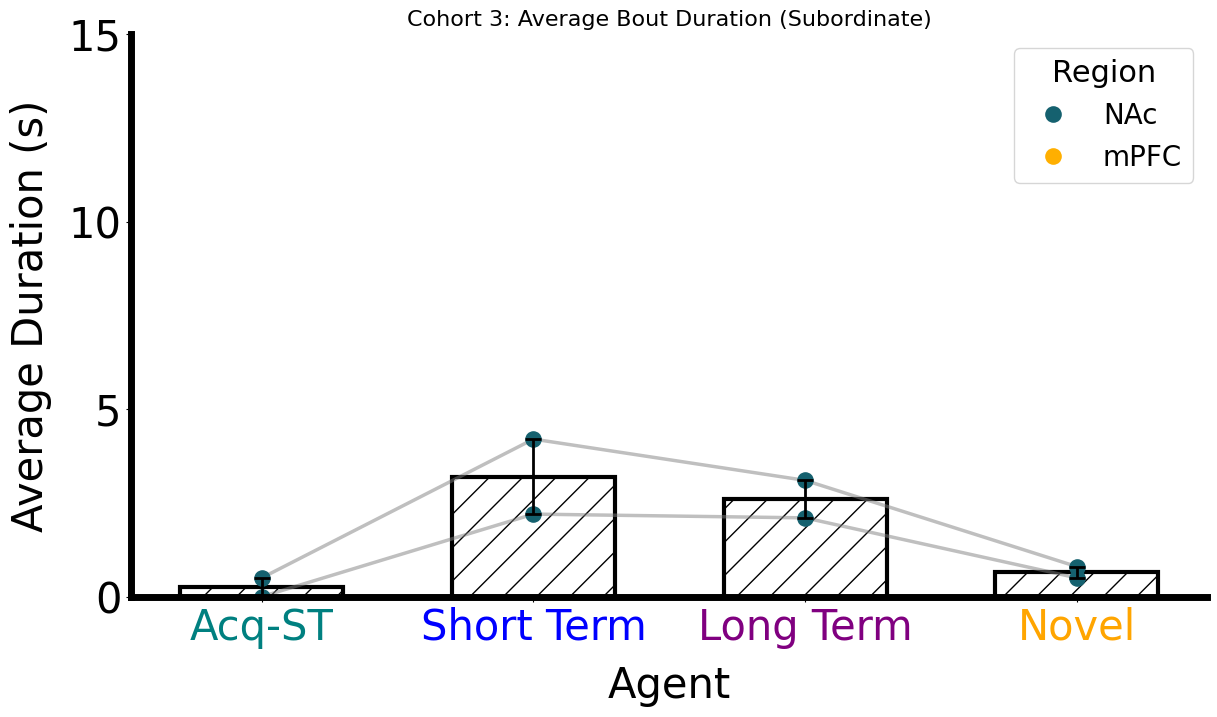

In [19]:
#plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)

plot_y_across_bouts_gray(
    df=agent_df,
    title="Cohort 3: Average Bout Duration (Subordinate)",
    ylabel="Average Duration (s)",
    metric='Avg',  # OR 'Avg'
    rank_filter=4,  # Optional: plot only rank 1 mice
    custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(0, 15),
    yticks_increment=5,
    bar_fill_color='white',     
    bar_edge_color='black',     
    bar_linewidth=3,            
    bar_hatch='/'         
)



In [20]:
import pandas as pd

def assign_ranks_and_combine_da_metrics(experiment, rank_csv_path):
    """
    Assigns subject ranks (from CSV) to each trial's behaviors DataFrame after DA metrics are computed.
    Then combines all trials into a single DataFrame with columns:
    ['Subject', 'Rank', 'Behavior', 'Bout', 'Event_Start', 'Event_End', 'Duration (s)',
     'AUC', 'Max Peak', 'Time of Max Peak', 'Mean Z-score', 'Original End', 'Adjusted End']
    
    Returns:
        combined_df (DataFrame): All behaviors + DA metrics + Rank, with Subject column.
    """

    # Load rank CSV
    rank_df = pd.read_csv(rank_csv_path)
    if 'Subject' not in rank_df.columns or 'Rank' not in rank_df.columns:
        rank_df.columns = ['Subject', 'Rank']  # fallback if no headers
    rank_dict = dict(zip(rank_df['Subject'].str.lower(), rank_df['Rank']))

    combined_rows = []
    assigned = 0

    for trial_name, trial in experiment.trials.items():
        subj_id = trial_name[:3].lower()  # e.g., pp1, nn2
        rank = rank_dict.get(subj_id, None)

        if rank is not None and hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()
            df['Subject'] = subj_id
            df['Rank'] = rank
            combined_rows.append(df)
            assigned += 1
        else:
            print(f"Skipped trial '{trial_name}' — no rank match or empty behaviors.")

    combined_df = pd.concat(combined_rows, ignore_index=True)
    print(f"Ranks assigned to {assigned} trials. Combined DataFrame shape: {combined_df.shape}")
    
    return combined_df



In [21]:
combined_df = assign_ranks_and_combine_da_metrics(experiment, rank_csv_path=rank_csv_path)
combined_df

Ranks assigned to 8 trials. Combined DataFrame shape: (31, 13)


,Bout,Behavior,Event_Start,Event_End,Duration (s),AUC,Max Peak,Time of Max Peak,Mean Z-score,Original End,Adjusted End,Rank,Subject
0,Long_Term-1,Investigation,1190.8,1193.1,2.3,2.043572,2.596307,1191.237035,2.332582,1193.1,1191.676454,2,nn4
1,Novel-1,Investigation,1501.7,1517.5,15.8,13.478245,9.341657,1502.848912,7.466411,1517.5,1503.505583,2,nn4
2,Short_Term-1,Investigation,188.4,192.0,3.6,12.024687,7.089189,189.592040,5.219805,192.0,190.703858,2,nn4
3,Short_Term-2,Investigation,862.3,864.7,2.4,0.546582,1.592900,862.300061,1.425281,864.7,862.683446,2,nn4
4,Long_Term-1,Investigation,1478.5,1478.8,0.3,7.324921,5.005535,1479.791709,3.523783,1478.8,1480.579124,3,nn7
5,Novel-1,Investigation,862.2,864.8,2.6,6.866744,4.062729,863.487573,3.090158,864.8,864.422444,3,nn7
6,Short_Term-1,Investigation,213.4,215.1,1.7,4.124388,2.791902,214.513086,1.938471,215.1,215.527584,3,nn7
7,Short_Term-2,Investigation,1162.4,1165.1,2.7,-2.648932,-0.141576,1162.400540,-0.981144,1165.1,1165.100000,3,nn7
8,Long_Term-1,Investigation,1170.5,1179.0,8.5,2.564490,1.882944,1171.598845,1.513848,1179.0,1172.194567,2,nn8
9,Novel-1,Investigation,861.6,863.3,1.7,4.694173,3.418078,862.878088,2.480085,863.3,863.492488,2,nn8


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from matplotlib.lines import Line2D

def plot_da_metric_across_bouts(df,  
                                da_metric='Mean Z-score',  # New param
                                title='Mean DA Metric Across Bouts', 
                                ylabel='DA Value', 
                                custom_xtick_labels=None, 
                                custom_xtick_colors=None, 
                                ylim=None, 
                                bar_fill_color='white',     
                                bar_edge_color='black',     
                                bar_linewidth=3,            
                                bar_hatch='///',            
                                yticks_increment=None, 
                                xlabel='Agent',
                                figsize=(12,7), 
                                pad_inches=0.1,
                                rank_filter=None):
    """
    Plots the selected DA metric (e.g., AUC, Max Peak, Mean Z-score) per Agent with SEM bars and per-subject dots.

    Parameters:
        - df (DataFrame): Combined behaviors DataFrame including DA metrics and Rank.
        - da_metric (str): 'AUC', 'Max Peak', or 'Mean Z-score'.
        - rank_filter (int or None): If provided, plots only subjects of this rank.
        [Other params same as before]
    """

    # --- Filter Rank ---
    if rank_filter is not None:
        if "Rank" not in df.columns:
            print("Rank filtering requested, but 'Rank' column not found.")
            return
        df = df[df["Rank"] == rank_filter]
        if df.empty:
            print(f"No data for Rank {rank_filter}.")
            return
        print(f"Plotting Rank {rank_filter} subjects: {len(df['Subject'].unique())} unique subjects.")

    # --- Validate Metric ---
    valid_metrics = ['AUC', 'Max Peak', 'Mean Z-score']
    if da_metric not in valid_metrics:
        print(f"Invalid DA metric '{da_metric}'. Must be one of {valid_metrics}")
        return

    # --- Pivot Data: Subjects × Bouts (columns: Bouts, values: selected metric) ---
    pivot_df = (
        df.pivot_table(index='Subject', columns='Bout', values=da_metric, aggfunc='mean')
          .fillna(0)
    )

    if pivot_df.empty:
        print("Pivoted DataFrame is empty. Check input data.")
        return

    # --- T-tests ---
    def perform_t_tests(df_vals):
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }
        results = {}
        for key, (b1, b2) in comparisons.items():
            if b1 in df_vals.columns and b2 in df_vals.columns:
                paired = df_vals[[b1, b2]].dropna()
                if len(paired) > 1:
                    t_stat, p_value = ttest_rel(paired[b1], paired[b2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        return results

    t_test_results = perform_t_tests(pivot_df)

    # --- Stats ---
    mean_vals = pivot_df.mean()
    sem_vals = pivot_df.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # --- Bar Plot ---
    ax.bar(pivot_df.columns, mean_vals, yerr=sem_vals, capsize=6,
           color=bar_fill_color, edgecolor=bar_edge_color, linewidth=bar_linewidth,
           width=0.6, hatch=bar_hatch,
           error_kw=dict(elinewidth=2, capthick=2, zorder=5))

    # --- Lines + Colored Dots ---
    for subj_id, row in pivot_df.iterrows():
        prefix = str(subj_id).lower().strip()
        if prefix.startswith('n'):
            dot_color = '#15616F'  # NAc
        elif prefix.startswith('p'):
            dot_color = '#FFAF00'  # mPFC
        else:
            dot_color = 'gray'

        # Gray line
        ax.plot(pivot_df.columns, row.values, linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

        # Colored opaque dots (no border, behind error bars)
        ax.scatter(pivot_df.columns, row.values, color=dot_color,
                   s=120, alpha=1.0, zorder=1)

    # --- Labels ---
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=18)

    # --- X-ticks ---
    ax.set_xticks(np.arange(len(pivot_df.columns)))
    if custom_xtick_labels:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(pivot_df.columns, fontsize=26)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # --- Y-limits ---
    all_vals = np.concatenate([pivot_df.values.flatten(), mean_vals.values])
    if ylim is None:
        min_val = np.nanmin(all_vals)
        max_val = np.nanmax(all_vals)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # --- Y-ticks ---
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    # --- Aesthetic ---
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # --- Significance Markers ---
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05
        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }
        line_spacing = sig_y_offset * 2.5
        current_y = mean_vals.max() + sig_y_offset

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*"
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance,
                            fontsize=40, ha='center', color='black')
                    current_y += line_spacing

    '''
    # --- Legend for Dots ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='none', label='NAc',
               markerfacecolor='#15616F', markersize=12, markeredgewidth=0),
        Line2D([0], [0], marker='o', color='none', label='mPFC',
               markerfacecolor='#FFAF00', markersize=12, markeredgewidth=0)
    ]
    ax.legend(handles=legend_elements, title="Region", fontsize=20, title_fontsize=22,
              loc='upper right', frameon=True)
    '''
    # Save and show
    plt.tight_layout(pad=pad_inches)
    #plt.savefig(f'{title}_{da_metric}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.show()


Plotting Rank 4 subjects: 2 unique subjects.


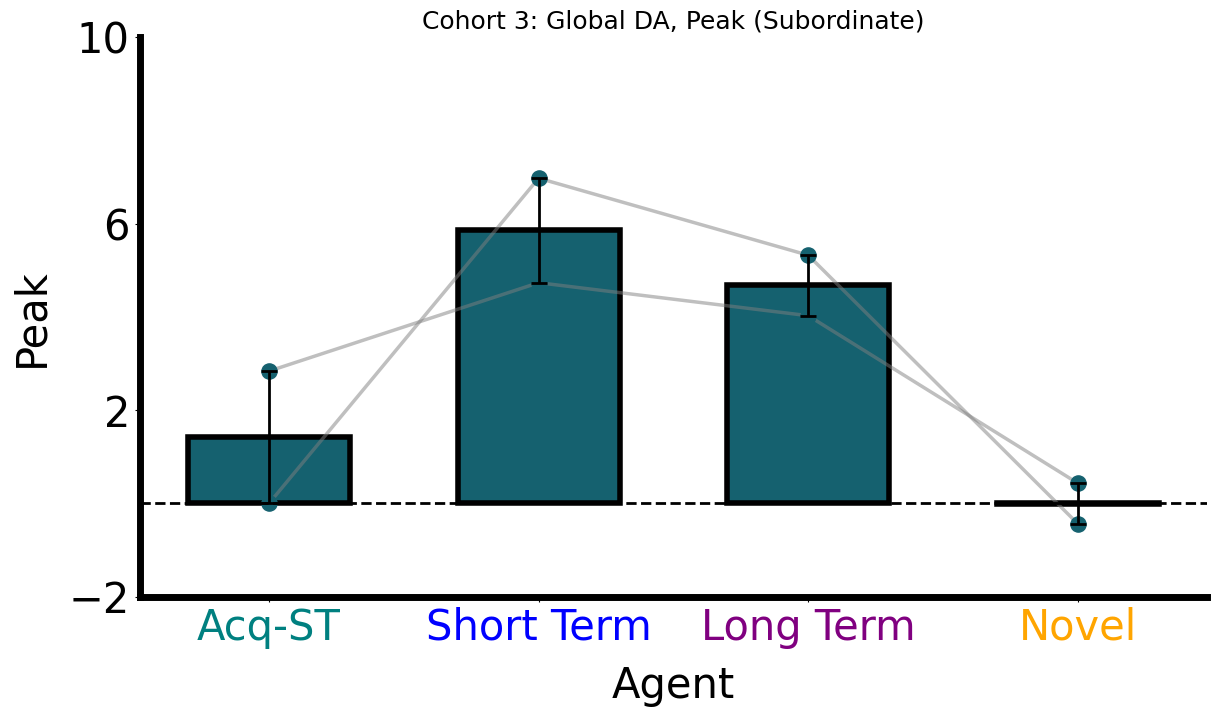

In [41]:
plot_da_metric_across_bouts(combined_df,
                            da_metric='Max Peak',
                            title='Cohort 3: Global DA, Peak (Subordinate)',
                            ylabel='Peak',
                            bar_fill_color=brain_region,
                            bar_edge_color="Black",
                            bar_linewidth=4,
                            bar_hatch=None,
                            rank_filter=4,  # Plot only Rank 1 mice
                            custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
                            custom_xtick_colors=["teal", "blue", "purple", "orange"],
                            ylim=(-2, 10),
                            yticks_increment=4)

#Mean Z-scored ∆F/F